# Exercise Series (Week 4/4)

The idea of this session is to apply Parareal on the Advection and Heat equation, and analyze its theoretical performance for both problems.

For both problem, we will consider Backward Euler time-integration and the same space discretization seen in Series 2 for those problems.

1. [Parareal for Heat Equation](#parareal-for-heat-equation)
2. [Parareal for Advection Equation](#parareal-for-advection-equation)

## Parareal for Heat Equation

Here we apply Parareal on

$$
\partial_t u = \partial_{xx} u + \sin(t),
$$

and the following space time domain :

$$
x\in [0, 1],\; t\in[0, 4\pi],\quad u(0, t) = u(1, t) = 0, \; u(x, 0) = 0.
$$

We consider second order centered finite difference for the space discretization, and Backward Euler for time discretization. The main idea is to solve the Heat equation in parallel and ensure a maximal discretization error ($L_2$ in space, $L_\infty$ in time) of $1e^{-2}$.

1. [Fine Solver Settings (Heat Equation)](#fine-solver-settings-heat-equation)
2. [Application of Parareal (Heat Equation)](#application-of-parareal-heat-equation)
3. [Optimizing Parareal Speedup for Heat Equation](#optimizing-parareal-speedup-for-heat-equation)

### Fine Solver Settings (Heat Equation)

Before computing any Parareal solution, we search for the best space-time discretization settings for our problem.
First, we set $J=25$ and compute a first solution using $400$ time steps :

In [1]:
import numpy as np
from pde import finDiffMatrixD2C2, backwardEulerLin

J = 25
A_diff = finDiffMatrixD2C2(J=J, L=1)
x = np.linspace(0, 1, J+2)[1:-1]

def source(t):
    return np.sum([np.sin((i+1)*t) for i in range(5)])

T = 2*np.pi
u0 = np.zeros(J)

nStep = 400
t, u = backwardEulerLin(A_diff, u0, source, 0, T, nStep)

Then we plot the solution over time, looking at the middle of the space domain and one of the boundary :

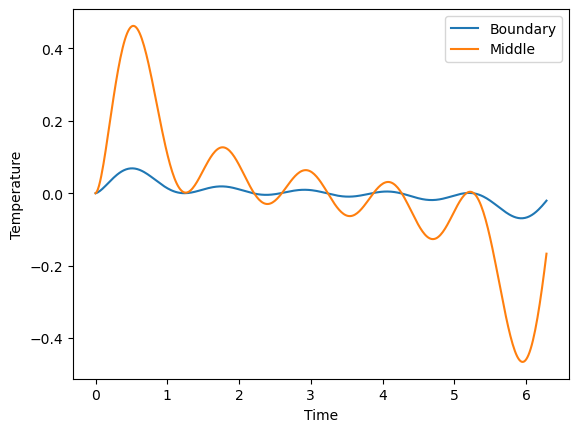

In [2]:
import matplotlib.pyplot as plt

plt.plot(t, u[0], label="Boundary")
plt.plot(t, u[J//2], label="Middle")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Temperature");

We see the impact of the source on the solution, that have a constant mean temperature over time in the middle of the space domain, and a smaller one at the boundary.

Now let us look at the global discretization error in time using a numerical approach as in Series 2, decreasing gradually the time-step size and comparing with a very fin reference solution.

> Note : To simplify our settings, we consider that $J=25$ is sufficient for the space discretization error to be negligible.

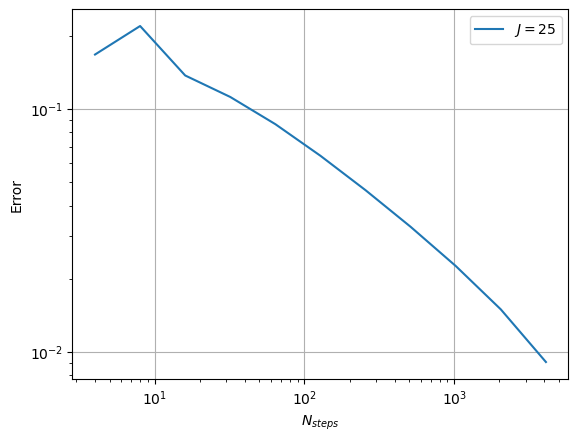

In [3]:
def plotTimeError(L=1, J=25, tEnd=T):

    u0 = np.zeros(J)

    A = finDiffMatrixD2C2(J, L)

    N_ref = 2**14
    _, u_ref = backwardEulerLin(A, u0, b=source, tBeg=0, tEnd=tEnd, N=N_ref)

    nSteps = 2**np.arange(2, 13)
    err = []
    for N in nSteps:
        _, u = backwardEulerLin(A, u0, b=source, tBeg=0, tEnd=tEnd, N=N)
        ref = u_ref[:, ::N_ref//N]
        error = np.linalg.norm(u-ref, ord=2, axis=-1)   # L_2 in space
        error = np.linalg.norm(error, ord=np.inf)       # L_infty in time 
        err.append(error)

    plt.loglog(nSteps, err, label=f"$J={J}$")
    plt.xlabel('$N_{steps}$')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plotTimeError()

From this experiment, we can see that for the whole time interval, we need around $4000$ time steps in order to satisfy our discretization error requirements ($1e^{-2}$).

### Application of Parareal (Heat Equation)

Now that we have our numerical settings for the fine solver, we consider that we have 10 processors available for Parareal, so apply it with $N=10$ :

In [4]:
nSteps = 4000
N = 10
nF = int(nSteps//N)
print('nF =', nF)

nF = 400


Now we import the `parareal` function implemented during Series 3, and define our coarse and fine solver : 

In [5]:
from pde import parareal

nG = 1

def fine(t0, t1, u0):
    _, u = backwardEulerLin(A_diff, u0, b=source, tBeg=t0, tEnd=t1, N=nF)
    return u[:, -1]

def coarse(t0, t1, u0):
    _, u = backwardEulerLin(A_diff, u0, b=source, tBeg=t0, tEnd=t1, N=nG)
    return u[:, -1]

Then we can run the Parareal algorithm, and plot the error with a reference solution using the fine solver in serial for all time sub-intervals :

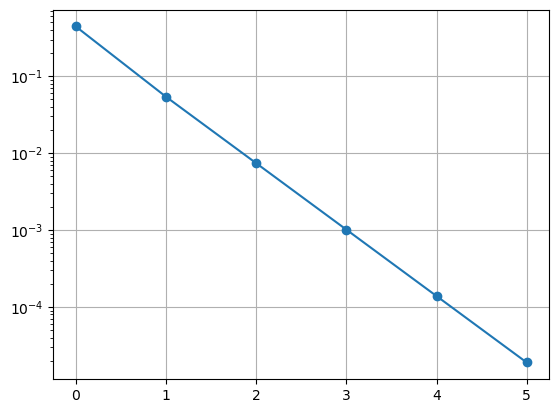

In [6]:
K = 5
u = parareal(fine, coarse, T, u0, N, K)

_, uFine = backwardEulerLin(A_diff, u0, b=source, tBeg=0, tEnd=T, N=N*nF)
uFine = uFine[:, ::nF].T

error = np.linalg.norm(uFine - u, axis=-1, ord=2)       # L_2 in space
error = np.linalg.norm(error, axis=-1, ord=np.inf)      # L_inf in time

plt.semilogy(error, 'o-')
plt.grid()

At this stage, we can see a nice convergence of the algorithm, and in particular we need $K=2$ iterations for the PinT error to be of the same order as the time discretization error.

Now, we can quickly estimate what is the parallel speedup for our algorithm if we stop there. Let us use an formula that model Parareal speedup (ignoring communication costs) :

$$
S = \frac{N C_F}{(N+K)C_G + K C_F}
$$

where $C_F$ is the cost of the fin solver, and $C_G$ is the cost of the coarse solver. This formula can be simplified as this :

$$
S = \frac{1}{\left(1+\frac{K}{N}\right)\frac{C_G}{C_F} + \frac{K}{N}}
$$

so we can see it depends only on two ratio :

- $R_1 = \frac{C_G}{C_F}$ : cost ratio between coarse and fine solver on one sub-interval
- $R_2 = \frac{K}{N}$ : ratio between iterations number and number of sub-intervals

In particular, since we use the same time integrator (Backward Euler), without too much approximation we can say that $R_1 = N_G/N_F$, where $N_F$ and $N_G$ are respectively the number of fine and coarse time steps on each time sub-intervals.

So let us compute this speedup for our case :

In [7]:
def speedup(R1, R2):
    return 1/((1+R2)*R1 + R2)

R1 = nG/nF
R2 = 2/N
s = speedup(R1, R2)

print(f'Speedup : {s:1.1f} (parallel efficiency = {s/N:1.2f})')

Speedup : 4.9 (parallel efficiency = 0.49)


### Optimizing Parareal Speedup for Heat Equation

In the previous experiments, even if we got some speedup with Parareal, the overall parallel efficiency (ideally $1$) is actually small. However, we choose to use one coarse time step per sub-interval, which produces a very low cost ratio ($R_1 = 1/300$).

Now we can see what happen if we decide to use a coarse solver slightly more accurate, using $N_G=2$ (cost ratio $R_1 = 1/150$) :

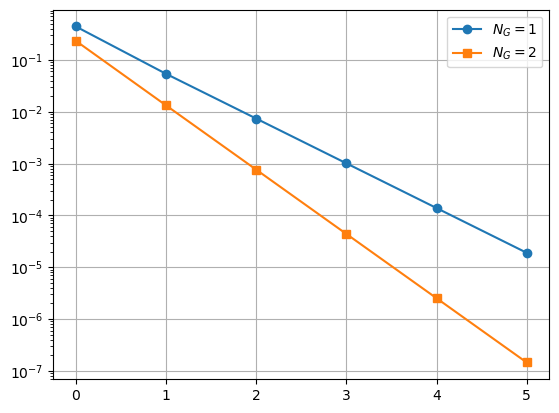

In [8]:
_, uFine = backwardEulerLin(A_diff, u0, b=source, tBeg=0, tEnd=T, N=N*nF)
uFine = uFine[:, ::nF].T

def plotConvergence(nG, K=5, sym='o-'):

    def coarse(t0, t1, u0):
        _, u = backwardEulerLin(A_diff, u0, b=source, tBeg=t0, tEnd=t1, N=nG)
        return u[:, -1]

    u = parareal(fine, coarse, T, u0, N, K)

    error = np.linalg.norm(uFine - u, axis=-1, ord=2)
    error = np.linalg.norm(error, axis=-1, ord=np.inf)

    plt.semilogy(error, sym, label=f"$N_G = {nG}$")
    plt.legend()
    plt.grid(True)

plotConvergence(nG=1)
plotConvergence(nG=2, sym='s-')

We can see that the number of required iterations is smaller now, but since $R_1$ also changed, this will impact our new speedup. So let's compute the estimation for $N_G=2$ if we stop at one iteration :

In [9]:
R1 = nG/nF
R2 = 1/N
s = speedup(R1, R2)
print(f'Speedup : {s:1.1f} (parallel efficiency = {s/N:1.2f})')

Speedup : 9.7 (parallel efficiency = 0.97)


As a matter of fact, using the coarse solver with $N_G=2$ provides a better speedup than with $N_G=1$, so playing even more with this parameter could allow to optimize the speedup we can get with Parareal.

Let us investigate this with numerical experiments :

In [10]:
_, uFine = backwardEulerLin(A_diff, u0, b=source, tBeg=0, tEnd=T, N=N*nF)

def estimateSpeedup(nG, T=T, N=N, nF=nF, tol=1e-2):

    def fine(t0, t1, u0):
        _, u = backwardEulerLin(A_diff, u0, b=source, tBeg=t0, tEnd=t1, N=nF)
        return u[:, -1]

    def coarse(t0, t1, u0):
        _, u = backwardEulerLin(A_diff, u0, b=source, tBeg=t0, tEnd=t1, N=nG)
        return u[:, -1]
    
    u = parareal(fine, coarse, T, u0, N, K=N-2)
    uRef = uFine[:, ::nF].T

    error = np.linalg.norm(uRef - u, axis=-1, ord=2)
    error = np.linalg.norm(error, axis=-1, ord=np.inf)

    kMin = np.argmax(error < tol)

    R1 = nG/nF
    R2 = kMin/N

    return speedup(R1, R2)

This function will run the almost all parareal iterations, check automatically how much iterations we need to reach a PinT of the same order as the time discretization error, and compute the speedup estimate.

Let use run this function on different values for $N_G$ :

In [11]:
nG = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sMax = [estimateSpeedup(n) for n in nG]

Now let us plot the speedup in function of $N_G$ :

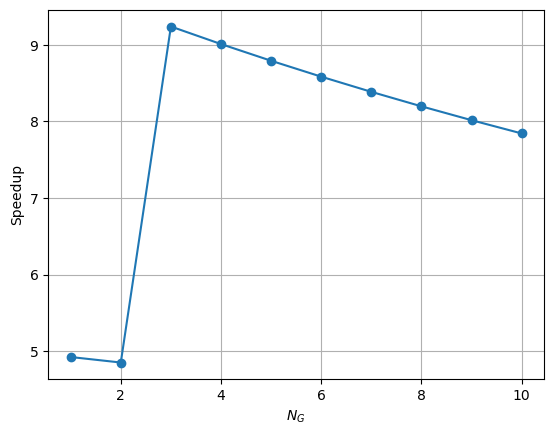

In [12]:
plt.plot(nG, sMax, 'o-', label="$N=10$, $N_F=400$")
plt.xlabel("$N_G$")
plt.ylabel("Speedup")
plt.grid()

We can see that the maximal theoretical speedup increase by step with $N_G$, up to a point where we reach a maximum value $N_G=3$ and then the theoretical speedup decrease.

This is mostly due to Parareal needing less and less iteration as the coarse solver accuracy increase. In fact, for $N_G=3$, it only need one iteration to get the correct accuracy :

In [13]:
R1 = 3/nF
R2 = 1/N
s = speedup(R1, R2)
print(f'Speedup : {s:1.1f} (parallel efficiency = {s/N:1.2f})')

Speedup : 9.2 (parallel efficiency = 0.92)


Furthermore, since the number of Parareal iterations has actually a big impact on the theoretical speedup, reducing it to it's lowest value is actually better than trying to get a very cheap coarse solver.

This is a very important aspect to consider when using Parareal, as usually people present the algorithm and tels that they want a very cheap coarse solver. But in fact, a preferable approach is :

1. Find the accuracy of the coarse solver that minimize the number of iterations
2. Make the coarse solver very cheap, eventually compromising with point 1

**To go further :** you can also look at a different number of processors in time (different $N$), and check if you can also optimize the parallel efficiency of Parareal on this problem.

## Parareal for Advection Equation

Now we apply Parareal on

$$
\partial_t u = -\partial_{x} u,
$$

and the following space time domain :

$$
x\in [0, 2\pi],\; t\in[0, \pi],\quad u(0, t) = u(2\pi, t), \; u(x, 0) = \cos(x) + \cos(2x) + \cos(3x).
$$

We consider first order upwind finite difference for the space discretization, and Backward Euler for time discretization. The main idea is to investigate how Parareal struggle with this problem.

1. [Fine Solver Settings (Advection Equation)](#fine-solver-settings-advection-equation)
2. [Parareal Convergence for Advection (with Diffusion)](#parareal-convergence-for-advection-with-diffusion)
3. [Parareal for non-diffusive Advection](#parareal-for-non-diffusive-advection)

### Fine Solver Settings (Advection Equation)

First, let us look at one given problem

In [14]:
import numpy as np
from pde import finDiffMatrixD1U1, backwardEulerLin

J = 30
L = 2*np.pi
A_adv = -finDiffMatrixD1U1(J=J, L=L)
x = np.linspace(0, 2*np.pi, num=J, endpoint=False)

def source(t):
    return 0

T = np.pi

def initialSolution(x):
    return np.cos(x) + np.cos(2*x) + np.cos(3*x)

u0 = initialSolution(x)

nStep = 4000
t, u = backwardEulerLin(A_adv, u0, source, 0, T, nStep)

We deliberately choose a very small time interval here, as we will see later that the advection equation is very hard to solve accurately with this space-time discretization ...

We plot the solution at different times :

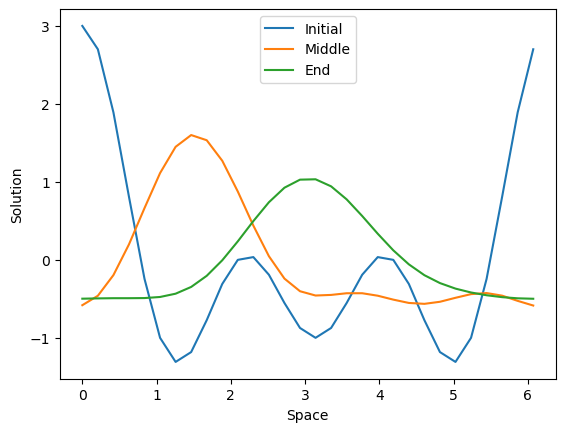

In [15]:
import matplotlib.pyplot as plt

plt.plot(x, u[:, 0], label="Initial")
plt.plot(x, u[:, nStep//2], label="Middle")
plt.plot(x, u[:, -1], label="End")
plt.legend()
plt.xlabel("Space")
plt.ylabel("Solution");

We can see that most component in the initial solution a quickly damped, which is mostly due to the space discretization scheme being quite diffusive. But let us keep this for now and try to correct it later.

So first we look at the time discretization error for this given problem in space, and try to get it below a given threshold :

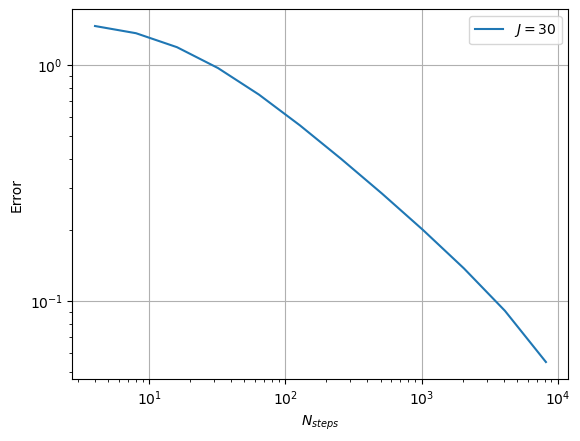

In [16]:
def plotTimeError(L=L, J=J, T=T):

    x = np.linspace(0, L, num=J, endpoint=False)
    u0 = initialSolution(x)

    A = -finDiffMatrixD1U1(J, L)

    N_ref = 2**15
    _, u_ref = backwardEulerLin(A, u0, b=source, tBeg=0, tEnd=T, N=N_ref)

    nSteps = 2**np.arange(2, 14)
    err = []
    for N in nSteps:
        _, u = backwardEulerLin(A, u0, b=source, tBeg=0, tEnd=T, N=N)
        ref = u_ref[:, ::N_ref//N]
        error = np.linalg.norm(u-ref, ord=2, axis=-1)   # L_2 in space
        error = np.linalg.norm(error, ord=np.inf)       # L_infty in time 
        err.append(error)

    plt.loglog(nSteps, err, label=f"$J={J}$")
    plt.xlabel('$N_{steps}$')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plotTimeError()

Here we can see that we need a very small time steps ($N_{steps}=4000$) to solve the advection equation on a very small time interval with a tolerance of $1e^{-1}$. So let us choose this tolerance also later for Parareal ...

### Parareal Convergence for Advection (with Diffusion)

In [17]:
nStep = 4000
N = 10
nF = int(nStep//N)
print("nF =", nF)

nF = 400


As before, we define the coarse and fine solver for Parareal, using similar time-step ratio as for the heat equation :

In [18]:
nG = 1

def fine(t0, t1, u0):
    _, u = backwardEulerLin(A_adv, u0, b=source, tBeg=t0, tEnd=t1, N=nF)
    return u[:, -1]

def coarse(t0, t1, u0):
    _, u = backwardEulerLin(A_adv, u0, b=source, tBeg=t0, tEnd=t1, N=nG)
    return u[:, -1]

Then we run Parareal for 5 iterations, and observe the PinT error using the fine sequential solution as reference :

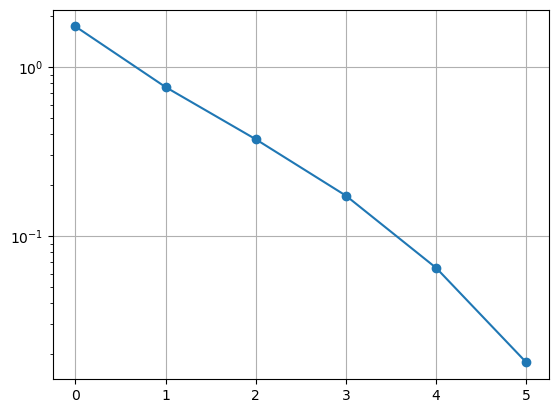

In [19]:
K = 5
u = parareal(fine, coarse, T, u0, N, K)

_, uFine = backwardEulerLin(A_adv, u0, b=source, tBeg=0, tEnd=T, N=N*nF)
uFine = uFine[:, ::nF].T

error = np.linalg.norm(uFine - u, axis=-1, ord=2)       # L_2 in space
error = np.linalg.norm(error, axis=-1, ord=np.inf)      # L_inf in time

plt.semilogy(error, 'o-')
plt.grid()

We see now that Parareal need more iteration for the PinT error to go under the fine solver discretization, even if the last one is not very low ($1e^{-1}$). 

If we compute the speedup for this case, we get :

In [20]:
R1 = nG/nF
R2 = 4/N
s = speedup(R1, R2)
print(f'Speedup : {s:1.1f} (parallel efficiency = {s/N:1.2f})')

Speedup : 2.5 (parallel efficiency = 0.25)


This is particularly low for parallel computation with 10 processors. But we can still try to improve this considering by improving the accuracy of the coarse solver :

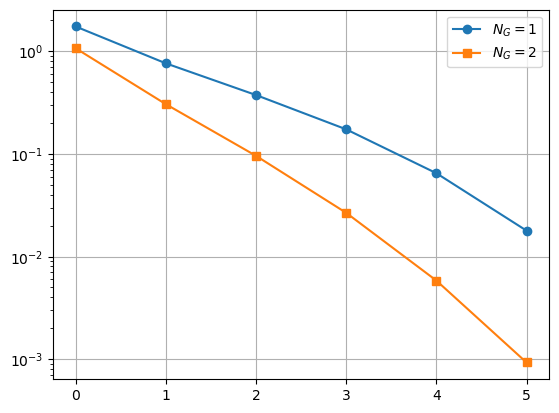

In [21]:
_, uFine = backwardEulerLin(A_adv, u0, b=source, tBeg=0, tEnd=T, N=N*nF)
uFine = uFine[:, ::nF].T

def plotConvergence(nG, K=5, sym='o-'):

    def coarse(t0, t1, u0):
        _, u = backwardEulerLin(A_adv, u0, b=source, tBeg=t0, tEnd=t1, N=nG)
        return u[:, -1]

    u = parareal(fine, coarse, T, u0, N, K)

    error = np.linalg.norm(uFine - u, axis=-1, ord=2)
    error = np.linalg.norm(error, axis=-1, ord=np.inf)

    plt.semilogy(error, sym, label=f"$N_G = {nG}$")
    plt.legend()
    plt.grid(True)

plotConvergence(nG=1)
plotConvergence(nG=2, sym='s-')

Now we only need 2 iterations to converge, and the speedup is :

In [22]:
R1 = 2/nF
R2 = 2/N
s = speedup(R1, R2)
print(f'Speedup : {s:1.1f} (parallel efficiency = {s/N:1.2f})')

Speedup : 4.9 (parallel efficiency = 0.49)


Now let us estimate the speedup considering different values for $N_G$ :

In [23]:
_, uFine = backwardEulerLin(A_adv, u0, b=source, tBeg=0, tEnd=T, N=N*nF)

def estimateSpeedupAdv(nG, T=T, N=N, nF=nF, tol=1e-1):

    def fine(t0, t1, u0):
        _, u = backwardEulerLin(A_adv, u0, b=source, tBeg=t0, tEnd=t1, N=nF)
        return u[:, -1]

    def coarse(t0, t1, u0):
        _, u = backwardEulerLin(A_adv, u0, b=source, tBeg=t0, tEnd=t1, N=nG)
        return u[:, -1]
    
    u = parareal(fine, coarse, T, u0, N, K=N-2)
    uRef = uFine[:, ::nF].T

    error = np.linalg.norm(uRef - u, axis=-1, ord=2)
    error = np.linalg.norm(error, axis=-1, ord=np.inf)

    kMin = np.argmax(error < tol)

    R1 = nG/nF
    R2 = kMin/N

    return speedup(R1, R2)

In [24]:
nG = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sMax = [estimateSpeedupAdv(n) for n in nG]

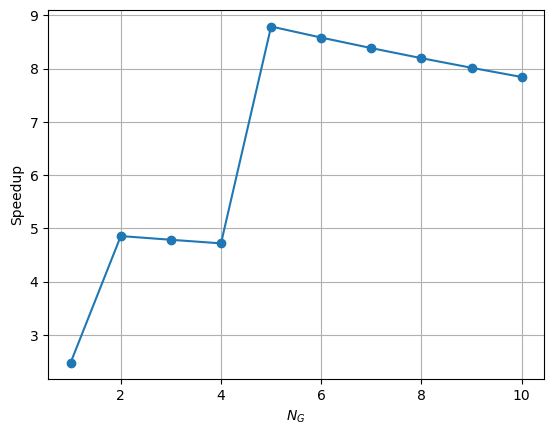

In [25]:
plt.plot(nG, sMax, 'o-', label="$N=10$, $N_F=400$")
plt.xlabel("$N_G$")
plt.ylabel("Speedup")
plt.grid()

Here we see again this high improvement by steps, where increasing the accuracy of the coarse solver allows to iterate up to one iteration only. Thanks to that, we a speedup a bit below 9, which is still a reasonable parallel efficiency for Parareal.

However, this was obtained considering an important amount of diffusion brought by the numerical scheme. So let us try to correct that problem, and apply Parareal again ...

### Parareal for non-diffusive Advection

In order to reduce the diffusion brought by the numerical scheme, we propose to use a finite difference of order 2 :

$$
\partial_{x} u(x_j) = \frac{u_{j+1}-u_{j-1}}{\Delta{x}}
$$

We implement it using the following function :

In [26]:
import scipy.linalg as spl

def finDiffMatrixD1C2(J, L):
    h = L/J
    A = spl.circulant([0, -1.]+(J-3)*[0.] + [1.])
    A /= 2*h
    return A

Then we use this for our initial problem :

In [27]:
J = 30
L = 2*np.pi
A_adv = -finDiffMatrixD1C2(J=J, L=L)
x = np.linspace(0, 2*np.pi, num=J, endpoint=False)

def source(t):
    return 0

T = np.pi

def initialSolution(x):
    return np.cos(x) + np.cos(2*x) + np.cos(3*x)

u0 = initialSolution(x)

nStep = 4000
t, u = backwardEulerLin(A_adv, u0, source, 0, T, nStep)

And check how the solution looks like now :

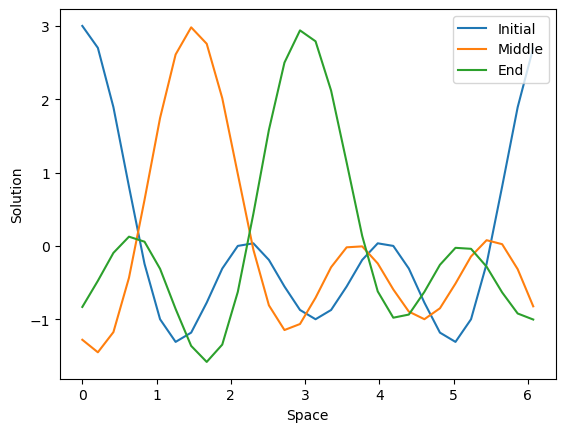

In [28]:
import matplotlib.pyplot as plt

plt.plot(x, u[:, 0], label="Initial")
plt.plot(x, u[:, nStep//2], label="Middle")
plt.plot(x, u[:, -1], label="End")
plt.legend()
plt.xlabel("Space")
plt.ylabel("Solution");

We can see now that the amount of diffusion is very low compared to the upwind scheme, and the error in space seems to be negligible now.

Then let's estimate the time discretization error :

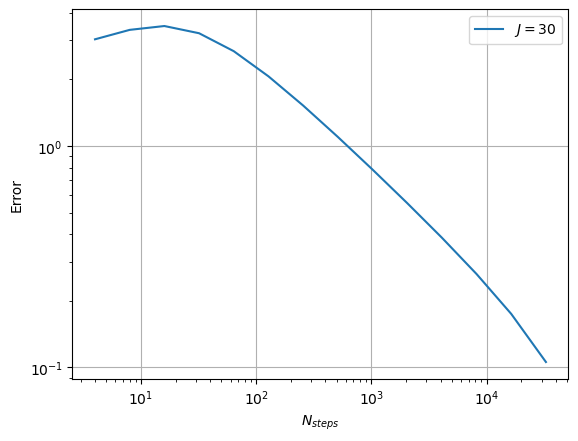

In [29]:
def plotTimeError(L=L, J=J, T=T):

    x = np.linspace(0, L, num=J, endpoint=False)
    u0 = initialSolution(x)

    A = -finDiffMatrixD1C2(J, L)

    N_ref = 2**17
    _, u_ref = backwardEulerLin(A, u0, b=source, tBeg=0, tEnd=T, N=N_ref)

    nSteps = 2**np.arange(2, 16)
    err = []
    for N in nSteps:
        _, u = backwardEulerLin(A, u0, b=source, tBeg=0, tEnd=T, N=N)
        ref = u_ref[:, ::N_ref//N]
        error = np.linalg.norm(u-ref, ord=2, axis=-1)   # L_2 in space
        error = np.linalg.norm(error, ord=np.inf)       # L_infty in time 
        err.append(error)

    plt.loglog(nSteps, err, label=f"$J={J}$")
    plt.xlabel('$N_{steps}$')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plotTimeError()

Now we see that a larger number of time-steps ($N_{steps} = 40000$) is required to get below the $1e^{-1}$ tolerance.

But let's try to use this an apply Parareal with this settings :

nF = 4000


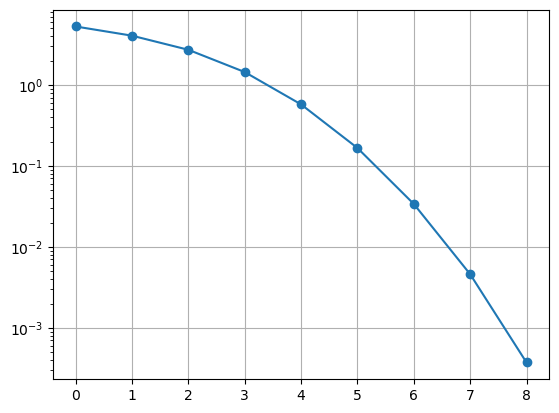

In [30]:
nStep = 40000
N = 10
nF = int(nStep//N)
print("nF =", nF)

def fine(t0, t1, u0):
    _, u = backwardEulerLin(A_adv, u0, b=source, tBeg=t0, tEnd=t1, N=nF)
    return u[:, -1]

nG = 1
def coarse(t0, t1, u0):
    _, u = backwardEulerLin(A_adv, u0, b=source, tBeg=t0, tEnd=t1, N=nG)
    return u[:, -1]

K = 8
u = parareal(fine, coarse, T, u0, N, K)

_, uFine = backwardEulerLin(A_adv, u0, b=source, tBeg=0, tEnd=T, N=N*nF)
uFine = uFine[:, ::nF].T

error = np.linalg.norm(uFine - u, axis=-1, ord=2)       # L_2 in space
error = np.linalg.norm(error, axis=-1, ord=np.inf)      # L_inf in time

plt.semilogy(error, 'o-')
plt.grid()

Now we need quite a lot of iterations ($K=6$) to reach our error tolerance, which gives the following speedup :

In [31]:
R1 = nG/nF
R2 = 6/N
s = speedup(R1, R2)
print(f'Speedup : {s:1.1f} (parallel efficiency = {s/N:1.2f})')

Speedup : 1.7 (parallel efficiency = 0.17)


We can eventually try to optimize the speedup by changing the number of time-step for the coarse solver :

In [32]:
_, uFine = backwardEulerLin(A_adv, u0, b=source, tBeg=0, tEnd=T, N=N*nF)

def estimateSpeedupAdvNDiff(nG, T=T, N=N, nF=nF, tol=1e-1):

    def fine(t0, t1, u0):
        _, u = backwardEulerLin(A_adv, u0, b=source, tBeg=t0, tEnd=t1, N=nF)
        return u[:, -1]

    def coarse(t0, t1, u0):
        _, u = backwardEulerLin(A_adv, u0, b=source, tBeg=t0, tEnd=t1, N=nG)
        return u[:, -1]
    
    u = parareal(fine, coarse, T, u0, N, K=N-2)
    uRef = uFine[:, ::nF].T

    error = np.linalg.norm(uRef - u, axis=-1, ord=2)
    error = np.linalg.norm(error, axis=-1, ord=np.inf)

    kMin = np.argmax(error < tol)

    R1 = nG/nF
    R2 = kMin/N

    return speedup(R1, R2)

In [33]:
nG = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]
sMax = [estimateSpeedupAdvNDiff(n) for n in nG]

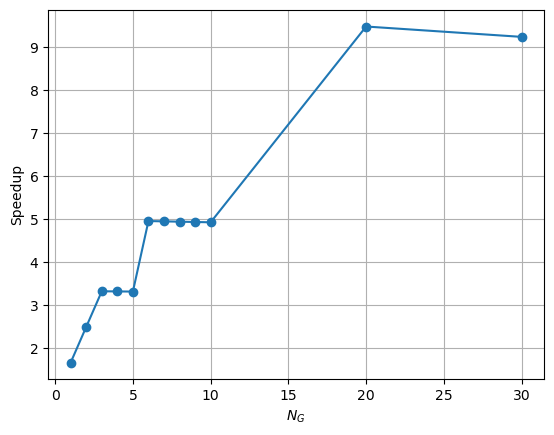

In [34]:
plt.plot(nG, sMax, 'o-', label="$N=10$, $N_F=4000$")
plt.xlabel("$N_G$")
plt.ylabel("Speedup")
plt.grid()